In [1]:
#imports
import sys
import os
import cv2
import matplotlib.pyplot as plt
import psutil
import pickle
import pandas as pd
import numpy as np
import torch
import torch_geometric
from torch_cluster import knn_graph
from torch_geometric.data import Data
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
# Add the root of the project to the path
sys.path.append(os.path.abspath("D:\\burtm\\Visual_studio_code\\PD_related_projects"))

d:\burtm\Visual_studio_code\conda_environments\GeneralPurposeML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA version: 12.6


In [3]:
def deserialize_keypoints(data):
    return [cv2.KeyPoint(x=pt[0], y=pt[1], size=size, angle=angle,
                         response=response, octave=octave, class_id=class_id)
            for pt, size, angle, response, octave, class_id in data]

In [4]:
#loading data
source_path="D:\\burtm\\Visual_studio_code\\PD_related_projects"
train_df = pd.read_csv(f"{source_path}\\outputs\\preprocessed_data\\icdar_train_df_patches_cc.csv")

# Load from file
with open(f"{source_path}\\outputs\\preprocessed_data\\keypoints_list_orb_300_patches.pkl", "rb") as f:
    metadata = pickle.load(f)

print(metadata["description"])
keypoints_list=metadata["keypoints_list"]
keypoints_list_deserialized = [deserialize_keypoints(kp) for kp in metadata["keypoints_list"]] # i don't need this for the gnn


created from icdar_train_df_patches.csv on 29/4/25. This dataset extract the top 10 patches for each writer independently of the iseng and same_text values


In [5]:
train_df.head()
train_zero_count = train_df[train_df['train'] == 0].shape[0]
print(f"Number of rows with train=0: {train_zero_count}")

Number of rows with train=0: 290


In [6]:
train_df.head()

,writer,same_text,isEng,train,file_name,male,x,y,x2,y2,n_cc
0,190,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,1,988,494,1482,988,315
1,24,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0,990,495,1485,990,311
2,26,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,1,494,1976,988,2470,309
3,190,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,1,494,494,988,988,303
4,160,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0,1482,494,1976,988,297


In [7]:
#I have to associate every point with n neighbors to have edges. 
#once i have the nodes matrix and edge connections i can define an architecture
#if it remains time also try extracting connected components to see if they work better than keypoints

#let's see the shape of our feature vector
print(keypoints_list[0][0])
print(keypoints_list[0][-1]) #-> y is the second element of the tuple
#it is a tuple in which the first element is a tuple and the other 5 are scalars

((228.0, 34.0), 31.0, 139.28248596191406, 0.03329368680715561, 0, -1)
((161.24317932128906, 204.24136352539062), 111.0786361694336, 225.11105346679688, 0.002198700560256839, 7, -1)


In [8]:
#i create a function to convert a list of keypoints into a matrix of features (as a pytorch tensor)
def keypoints_to_tensor(keypoints_list):
    # Extract the first keypoint from each list and convert to a numpy array
    keypoints_array = np.array([kp[0] for kp in keypoints_list])
    
    # Convert the list of tuples to a numpy array
    features_array = np.array([kp[1:] for kp in keypoints_list])
    
    # Concatenate the two arrays along the second axis (columns)
    combined_array = np.concatenate((keypoints_array, features_array), axis=1)
    tensor = torch.tensor(combined_array, dtype=torch.float32)
    
    return tensor

In [9]:
test_keypoints=keypoints_list[0]
test_tensor=keypoints_to_tensor(test_keypoints)
print(test_tensor.shape)
'''print(test_tensor[:2,:])
test_tensor[:, 0] *= 2
print(test_tensor[:2,:])'''

torch.Size([300, 7])


'print(test_tensor[:2,:])\ntest_tensor[:, 0] *= 2\nprint(test_tensor[:2,:])'

In [10]:
#now i write a function to create the adjacency matrix of the graph
def build_edges_knn(kps,dim='xy', k=5):
    # Compute pairwise distances
    if dim=='xy':
        pass
    elif dim=='x':
        #print(kps[:2,:])
        kps[:, 1:2]*=1000 #i artificially spread points on y -> x become more important
        #print(kps[:2,:])
    elif dim=='y':
        kps[:, 0:1]*=1000
    pos = kps[:, :2]
    edge_index = knn_graph(pos, k=k)
    return edge_index

In [11]:
edge_index = build_edges_knn(test_tensor,dim='xy', k=5) #you may add loop=True

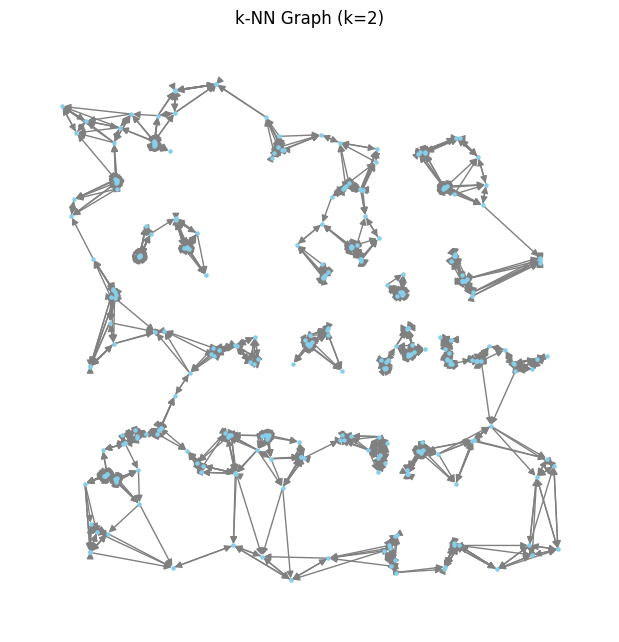

In [12]:
import networkx as nx
# Step 3: Create a NetworkX graph for visualization
G = nx.DiGraph()

# Add nodes with positions
for i, (x, y) in enumerate(test_tensor[:, :2]):
    G.add_node(i, pos=(x.item(), y.item()))

# Add directed edges
src, dst = edge_index
for s, d in zip(src, dst):
    G.add_edge(s.item(), d.item())

# Step 4: Plot
plt.figure(figsize=(6, 6))
nx.draw(
    G,
    pos=nx.get_node_attributes(G, 'pos'),
    with_labels=False,
    node_color='skyblue',
    node_size=5,
    arrows=True,
    edge_color='gray'
)
plt.title("k-NN Graph (k=2)")
plt.grid(True)
plt.show()

In [13]:
from torch_geometric.data import Data

data_list = []
num_graphs = len(keypoints_list)  # Number of graphs (or images)

for i in range(num_graphs):
    # Generate or load your data
    x = keypoints_to_tensor(keypoints_list[i])  # Tensor [num_nodes, num_features]
    edge_index = build_edges_knn(x,dim='xy', k=5)  # Tensor [2, num_edges]
    y = torch.tensor([train_df.loc[i,'male']], dtype=torch.long)  # Example target tensor [num_classes]

    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)
#devo ricordare di separare tra train e validation

In [14]:
from torch_geometric.data import InMemoryDataset

class MyGraphDataset(InMemoryDataset):
    def __init__(self, data_list):
        self.data_list = data_list
        super().__init__(None)

        self.data, self.slices = self.collate(data_list)

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]


In [15]:
from torch_geometric.loader import DataLoader
training_list = [data for i, data in enumerate(data_list) if train_df.loc[i,'train'] == 1]
train_dataset = MyGraphDataset(training_list)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

'''for batch in train_loader:
    print(batch.x.shape)           # All node features combined in one batch
    print(batch.edge_index.shape)  # Edge indices across the batch
    print(batch.batch.shape)       # Batch vector assigning nodes to graphs'''

'for batch in train_loader:\n    print(batch.x.shape)           # All node features combined in one batch\n    print(batch.edge_index.shape)  # Edge indices across the batch\n    print(batch.batch.shape)       # Batch vector assigning nodes to graphs'

In [16]:
batch = next(iter(train_loader))
print("Batch:", batch)
print("Labels:", batch.y[:])
print("Batch indices:", batch.batch[:])

Batch: DataBatch(x=[9620, 7], edge_index=[2, 48100], y=[32], batch=[9620], ptr=[33])
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1])
Batch indices: tensor([ 0,  0,  0,  ..., 31, 31, 31])


In [17]:
n_v=[len(data.x) for i, data in enumerate(data_list) if train_df.loc[i,'train'] == 1]
print(sum(n_v[:32])) #number of nodes in each graph

9606


In [18]:
validation_list = [data for i, data in enumerate(data_list) if train_df.loc[i,'train'] == 0]
val_dataset = MyGraphDataset(validation_list)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [19]:
print(train_dataset.num_node_features)
print(train_dataset.num_classes)
train_loader.batch_size

7
2


32

In [20]:
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
#DATASET_PATH = "D:\\burtm\\Visual_studio_code\\PD_related_projects\\outputs\\preprocessed_data\\"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "D:\\burtm\\Visual_studio_code\\PD_related_projects\\checkpoints\\"
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

Seed set to 42


cuda:0


In [21]:
gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv
}

In [22]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

In [23]:
class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in,
                            c_hidden=c_hidden,
                            c_out=c_hidden, # Not our prediction output yet!
                            **kwargs)
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
        x = self.head(x)
        return x

In [ ]:
class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = GraphGNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

    def forward(self, data):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)
        return x

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=0.0) # High lr because of small dataset and small model
        return optimizer

    def training_step(self, batch, batch_idx):
        logits = self.forward(batch)
        labels = batch.y.float() if self.hparams.c_out == 1 else batch.y
        loss = self.loss_module(logits, labels)

        if self.hparams.c_out == 1:
            preds = (logits > 0).float()
        else:
            preds = logits.argmax(dim=-1)

        acc = (preds == labels).sum().float() / preds.shape[0]
        self.log('train_loss', loss.item())
        self.log('train_acc', acc.item(), prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits = self.forward(batch)
        labels = batch.y.float() if self.hparams.c_out == 1 else batch.y
        loss = self.loss_module(logits, labels)

        if self.hparams.c_out == 1:
            preds = (logits > 0).float()
        else:
            preds = logits.argmax(dim=-1)

        acc = (preds == labels).sum().float() / preds.shape[0]
        self.log('val_loss', loss.item())
        self.log('val_acc', acc.item())
        return loss

    def test_step(self, batch, batch_idx):
        logits = self.forward(batch)
        labels = batch.y.float() if self.hparams.c_out == 1 else batch.y
        loss = self.loss_module(logits, labels)

        if self.hparams.c_out == 1:
            preds = (logits > 0).float()
        else:
            preds = logits.argmax(dim=-1)

        acc = (preds == labels).sum().float() / preds.shape[0]
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss
    
    '''def on_train_epoch_end(self):
        acc = self.train_acc.compute()
        print(f"Epoch {self.current_epoch}: Train Acc = {acc:.4f}")
        self.train_acc.reset()

    def on_validation_epoch_end(self):
        acc = self.val_acc.compute()
        print(f"Epoch {self.current_epoch}: Val Acc = {acc:.4f}")
        self.val_acc.reset()'''

In [32]:
def train_graph_classifier(model_name, **model_kwargs):
    pl.seed_everything(42)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=300,
                         enable_progress_bar=True)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = GraphLevelGNN(c_in=train_dataset.num_node_features,
                              c_out=1 if train_dataset.num_classes==2 else train_dataset.num_classes,
                              **model_kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # Test best model on validation and test set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, val_loader, verbose=False)
    result = {"val": test_result[0]['test_acc'], "train": train_result[0]['test_acc']}
    return model, result

In [26]:
'''# Initialize the model
model = GraphLevelGNN(
    c_in=train_dataset.num_node_features,
    c_out=1 if train_dataset.num_classes == 2 else train_dataset.num_classes,
    c_hidden=256,
    layer_name="GraphConv",
    num_layers=3,
    dp_rate_linear=0.5,
    dp_rate=0.0
)

# Select the first graph from the dataset
graph_data = train_dataset.get(0)

# Move the graph data and model to the appropriate device
graph_data = graph_data.to(device)
model = model.to(device)

# Test the model with the first graph
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(graph_data)

print("Model output:", output)
print("Graph data y:", graph_data.y)'''

'# Initialize the model\nmodel = GraphLevelGNN(\n    c_in=train_dataset.num_node_features,\n    c_out=1 if train_dataset.num_classes == 2 else train_dataset.num_classes,\n    c_hidden=256,\n    layer_name="GraphConv",\n    num_layers=3,\n    dp_rate_linear=0.5,\n    dp_rate=0.0\n)\n\n# Select the first graph from the dataset\ngraph_data = train_dataset.get(0)\n\n# Move the graph data and model to the appropriate device\ngraph_data = graph_data.to(device)\nmodel = model.to(device)\n\n# Test the model with the first graph\nmodel.eval()  # Set the model to evaluation mode\nwith torch.no_grad():\n    output = model(graph_data)\n\nprint("Model output:", output)\nprint("Graph data y:", graph_data.y)'

In [35]:
model, result = train_graph_classifier(model_name="GraphConv",
                                       c_hidden=1024,
                                       layer_name="GraphConv",
                                       num_layers=2,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | GraphGNNModel     | 2.1 M  | train
1 | loss_module | BCEWithLogitsLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.458     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 1:  56%|█████▋    | 45/80 [00:12<00:09,  3.71it/s, v_num=13, train_acc_step=0.562, train_acc_epoch=0.494]

d:\burtm\Visual_studio_code\conda_environments\GeneralPurposeML\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9658. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1: 100%|██████████| 80/80 [00:20<00:00,  3.82it/s, v_num=13, train_acc_step=0.500, train_acc_epoch=0.494]

d:\burtm\Visual_studio_code\conda_environments\GeneralPurposeML\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 603. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 3:  26%|██▋       | 21/80 [00:05<00:16,  3.66it/s, v_num=13, train_acc_step=0.500, train_acc_epoch=0.489]

d:\burtm\Visual_studio_code\conda_environments\GeneralPurposeML\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9655. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 3:  55%|█████▌    | 44/80 [00:11<00:09,  3.84it/s, v_num=13, train_acc_step=0.438, train_acc_epoch=0.489]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
pretrained_filename = 'D:\\burtm\Visual_studio_code\\PD_related_projects\\checkpoints\\GraphLevelGraphConv\\lightning_logs\\version_7\\checkpoints\\epoch=135-step=10880.ckpt'
model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)

In [ ]:
model.model

GraphGNNModel(
  (GNN): GNNModel(
    (layers): ModuleList(
      (0): GraphConv(7, 256)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): GraphConv(256, 256)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.0, inplace=False)
      (6): GraphConv(256, 256)
    )
  )
  (head): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
# Select the first graph from the dataset
graph_data = train_dataset.get(0)

# Move the graph data and model to the appropriate device
graph_data = graph_data.to(device)
model = model.to(device)

# Test the model with the first graph
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    output = model.forward(graph_data)




tensor([1.], device='cuda:0')
Model output: (tensor(0.6781, device='cuda:0'), tensor(1., device='cuda:0'))
Graph data y: tensor([1.], device='cuda:0')


In [ ]:
print(f"Train performance: {100.0*result['train']:4.2f}%")

Train performance: 48.61%


Model output: (tensor(0.7084, device='cuda:0'), tensor(0., device='cuda:0'))
Graph data y: tensor([0.], device='cuda:0')
